## Unimodal and crossmodal processing (Fig 5)
This code examines unimodal and crossmodal firing patterns of PER single neurons. 

Neurons were classified into visual, auditory, and crossmodal cell categories based on beta coefficients derived from multiple linear regression analysis (2. Multiple linear regression)

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import time

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
# Make sure you change "mother_path" properly to run this code
mother_path = Path('C:/multimodal-object-recognition-PER/')

fig_path = mother_path / 'result' / 'figures'
os.makedirs(fig_path,exist_ok=True)

### Parameter setting

In [4]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['tab:blue','tab:red','tab:gray']
color2 = ['tab:cyan','tab:pink','tab:gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
# load results from ANOVA
data_path = mother_path /'result'/'ANOVA'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')

# load results from multiple linear regression
data2_path = mother_path /'result'/'multiple linear regression'/'2023-07-10'
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

In [6]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [7]:
df = h5_to_df(f2)
df = df[(df['region']=='PER')&(df['response cell']==0)]
df.reset_index(inplace=True,drop=True)

for key in df['key']:  
    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = f[key].attrs['peak selectivity time']
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = f[key].attrs['selectivity index']
    df.loc[df['key']==key,'BG'] = f[key].attrs['BG']
    
    if f[key].attrs['preferred object'] == 'Boy':
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][3]
    else:
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][3]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1        

### Classifying visual, auditory, and crossmodal neurons

In [10]:
# classification based on permutation test (shuffling)
for i in range(len(df)):
    k = df.loc[i,'key']
    beta_diff = df.loc[i,'coef_pref_image']-df.loc[i,'coef_pref_sound']
    if df.loc[i,'pref_obj']=='Boy':
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])
    else:
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,2],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,3])
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df.loc[i,'Category'] = 'visual'
    elif beta_diff < auditory_crit:
        df.loc[i,'Category'] = 'auditory'
    else:
        df.loc[i,'Category'] = 'crossmodal'

In [11]:
x = [sum(df['Category']=='visual'), sum(df['Category']=='auditory'), sum(df['Category']=='crossmodal')]

print(f'Visual cell: {x[0]} / {np.sum(x)}')
print(f'Auditory cell: {x[1]} / {np.sum(x)}')
print(f'Crossmodal cell: {x[2]} / {np.sum(x)}')

Visual cell: 21 / 149
Auditory cell: 27 / 149
Crossmodal cell: 101 / 149


### Proportions of visual, auditory, and crossmodal cells (Fig 5E)

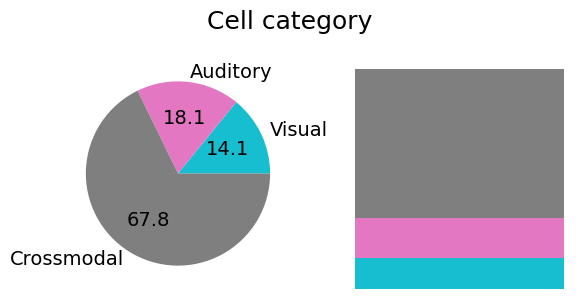

In [26]:
fig,ax = plt.subplots(1,2,figsize=(6,3))

fig.suptitle('Cell category', fontsize=18)
ax[0].pie(x,colors=color2,labels=['Visual','Auditory','Crossmodal'],autopct='%.1f',textprops={'fontsize':14});
ax[1].axis('off')
prev_data = 0
for i in range(3):
    ax[1].bar(1, height = x[i], bottom=prev_data, color=color2[i])
    prev_data += x[i]

plt.tight_layout()
#plt.savefig(fig_path / 'cell_porportion_pie_bar.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'cell_porportion_pie_bar.svg')

### Beta coefficients of all object cells (Fig 4C)

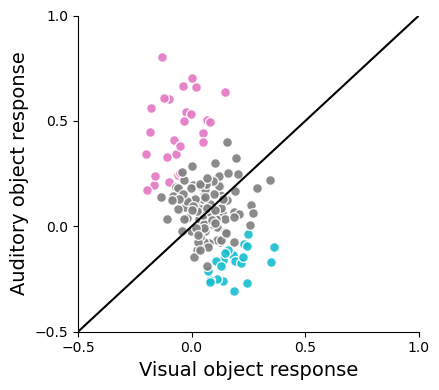

In [27]:
fig,ax = plt.subplots(figsize=(4.5,4))

gs = fig.add_gridspec(2,2, width_ratios=(4,1), height_ratios=(1,4))

#ax.scatter(df['coef_pref_image'],df['coef_pref_sound'], 
#           c = df['peak_selectivity_time_range'], cmap = 'viridis')
#norm = mpl.colors.Normalize(vmin=0,vmax=9)
#colormapping = mpl.cm.ScalarMappable(norm=norm,cmap=mpl.cm.viridis)
#fig.colorbar(colormapping, ax=plt.gca())

cat = ['visual','auditory','crossmodal']
colors = ['tab:cyan','tab:pink','tab:gray']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'coef_pref_image']
    y = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax.scatter(x, y, facecolors=colors[c],edgecolors='white',alpha=0.9, s=50)

ax.plot(np.arange(-1,2.1,0.5),np.arange(-1,2.1,0.5),color='black')
ax.set_xticks(np.arange(-1,2.1,0.5));
ax.set_yticks(np.arange(-1,2.1,0.5));
ax.set_xlim([-0.5,1])
ax.set_ylim([-0.5,1])

ax.set_xlabel('Visual object response',fontsize=14);
ax.set_ylabel('Auditory object response',fontsize=14);

plt.tight_layout()

#plt.savefig(fig_path / 'image_sound_scatter.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'image_sound_scatter.svg')

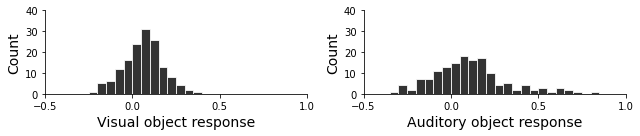

In [54]:
fig,ax = plt.subplots(1,2,figsize=(9,2))

x = ['coef_pref_image', 'coef_pref_sound']
xlabel = ['Visual object response', 'Auditory object response']

for i in range(2):
    ax[i].hist(df[x[i]], color='black', bins=np.arange(-0.5,1,0.05), alpha=0.8, ec='white');
    ax[i].set_xlabel(xlabel[i], fontsize=14);
    ax[i].set_xticks(np.arange(-0.5,1.5,0.5));
    ax[i].set_xlim([-0.5,1])
    ax[i].set_ylabel('Count', fontsize=14);
    ax[i].set_yticks(np.arange(0,45,10));

plt.tight_layout()
#plt.savefig(fig_path / 'image_sound_hist.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'image_sound_hist.svg')

### Comparing beta1 and beta2 in all object cells (Fig 4D)

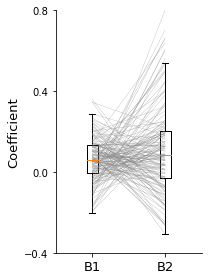

In [56]:
fig,ax = plt.subplots(figsize=(3,4))

ax.boxplot([df['coef_pref_image'], df['coef_pref_sound']], showfliers=False,);
for i in range(len(df)):
    ax.plot([1,2], [df.loc[i,'coef_pref_image'], df.loc[i,'coef_pref_sound']],
            linewidth=0.2, color='tab:gray')
ax.set_xticklabels(['B1', 'B2'], fontsize=13);
ax.set_yticks(np.arange(-0.4,0.9,0.4));
ax.set_ylim([-0.4,0.8])
ax.set_ylabel('Coefficient', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'duration_box_object_response.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'b1_b2_boxplot.svg')

In [57]:
pg.wilcoxon(df['coef_pref_image'],df['coef_pref_sound'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,4794.0,two-sided,0.132888,-0.142013,0.444484


### Recording sites and beta coefficients (Fig 4F)

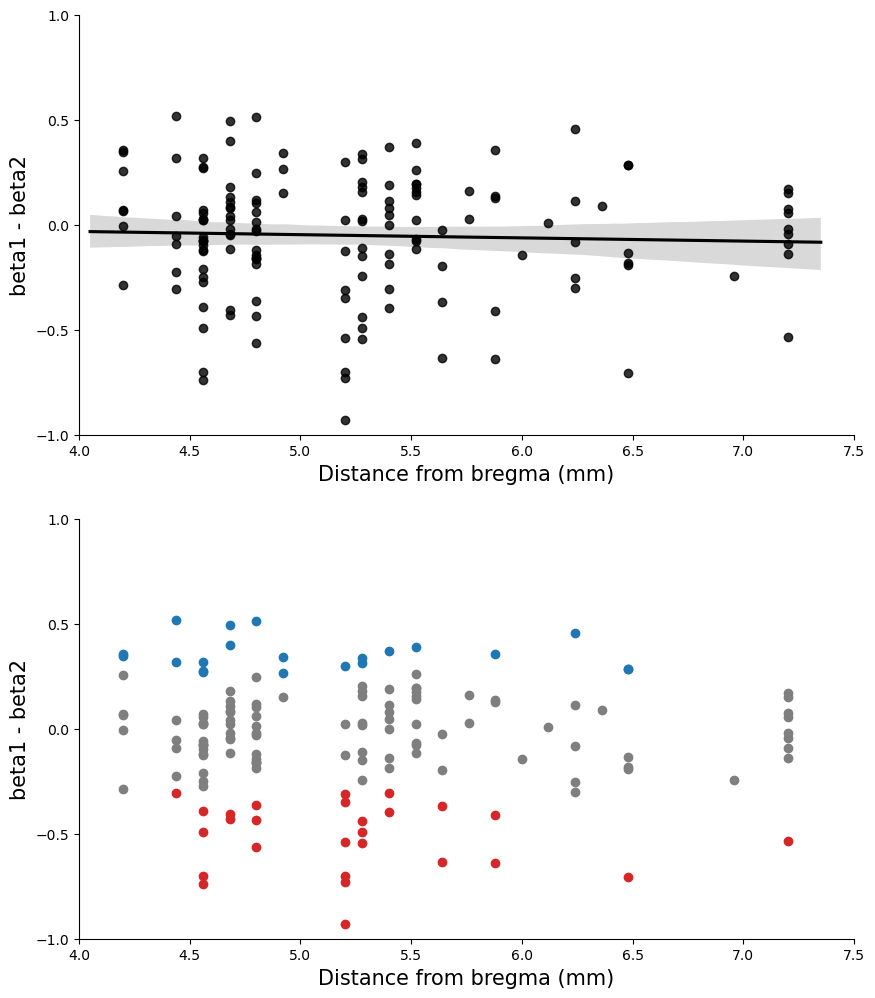

In [9]:
df.loc[df.BG==7.24,'BG'] = 7.2
df['coef_diff'] = df['coef_pref_image']-df['coef_pref_sound']

cat = ['visual','auditory','crossmodal']
marker = ['s', '^', 'o']

fig,ax = plt.subplots(2,1,figsize=(10,12))

sns.regplot(x='BG', y='coef_diff', data=df, ax=ax[0], truncate=False, color='black')
ax[0].set_yticks(np.arange(-1, 1.1, 0.5));
ax[0].set_ylim([-1, 1])
ax[0].set_ylabel('beta1 - beta2',fontsize=15)
#ax[0].set_xticks(np.sort(df['BG'].unique()))
#ax[0].set_xticklabels(np.sort(df['BG'].unique())*-1)
ax[0].set_xticks(np.arange(4,8,0.5))
ax[0].set_xlim([4,7.5])
#ax[0].tick_params(axis='x',labelrotation=45)
ax[0].set_xlabel('Distance from bregma (mm)',fontsize=15);

for i in range(len(df)):
    category = df.loc[i, 'Category']
    color_index = cat.index(category)
    ax[1].scatter(x=df.loc[i, 'BG'], y=df.loc[i, 'coef_diff'], color=color[color_index])
ax[1].set_yticks(np.arange(-1, 1.1, 0.5));
ax[1].set_ylim([-1, 1])
ax[1].set_ylabel('beta1 - beta2',fontsize=15)
#ax[1].set_xticks(np.sort(df['BG'].unique()))
#ax[1].set_xticklabels(np.sort(df['BG'].unique())*-1)
ax[1].set_xticks(np.arange(4,8,0.5))
ax[1].set_xlim([4,7.5])
#ax[1].tick_params(axis='x',labelrotation=45)
ax[1].set_xlabel('Distance from bregma (mm)',fontsize=15);

#plt.savefig(fig_path / 'anatomy_category_scatter.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'anatomy_category_scatter.svg')